In [689]:
import numpy as np
import pandas as pd
import joblib
from keras import Sequential
from keras.layers import Dense, GRU, Dropout, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt

In [690]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [691]:
def build_GRU_model(input_shape):
    model = Sequential(name="GRU")

    model.add(Input(shape=input_shape))
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units=64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units=32))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss="mean_squared_error")

    return model

In [692]:
df = pd.read_csv("../data/processed/mbajk_processed.csv")
df.head()

,available_bike_stands,apparent_temperature,surface_pressure,temperature,dew_point,date
0,8,24.7,984.3,25.1,12.4,2023-06-25 19:07:30+00:00
1,7,23.3,984.5,24.2,10.9,2023-06-25 19:33:48+00:00
2,6,23.3,984.5,24.2,10.9,2023-06-25 19:45:44+00:00
3,8,23.3,984.5,24.2,10.9,2023-06-25 19:55:29+00:00
4,12,23.3,984.5,24.2,10.9,2023-06-25 20:02:16+00:00


In [693]:
df.shape

(18692, 6)

In [694]:
target = "available_bike_stands"
features = [target] + [col for col in df.columns if col != target and col != "date"]

dataset = df[features]

In [695]:
dataset.shape

(18692, 5)

In [696]:
test_split = round(len(dataset) * 0.2)

train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [697]:
print(train_data.shape, test_data.shape)

(14954, 5) (3738, 5)


In [698]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [699]:
window_size = 50

target_col_idx = df.columns.get_loc(target)

feature_cols_idx = [df.columns.get_loc(col) for col in features]

print(f"Target column index: {target_col_idx}")
print(f"Feature columns index: {feature_cols_idx}")

Target column index: 0
Feature columns index: [0, 1, 2, 3, 4]


In [700]:
X_train, y_train = create_multivariate_time_series(train_data, window_size, target_col_idx, feature_cols_idx)
X_test, y_test = create_multivariate_time_series(test_data, window_size, target_col_idx, feature_cols_idx)

print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (14904, 50, 5), y_train: (14904,)
Shape of testing data: X_test: (3688, 50, 5), y_test: (3688,)


In [701]:
input_shape = (X_train.shape[1], X_train.shape[2])

models = [build_GRU_model(input_shape)]

history = {}

In [702]:
for model in models:
    print(f"Training {model.name} model")
    fit_result = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)
    history[model.name] = fit_result.history

Training GRU model
Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.0643 - val_loss: 0.0049
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 9/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 10/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0034 - val_loss: 0.0048


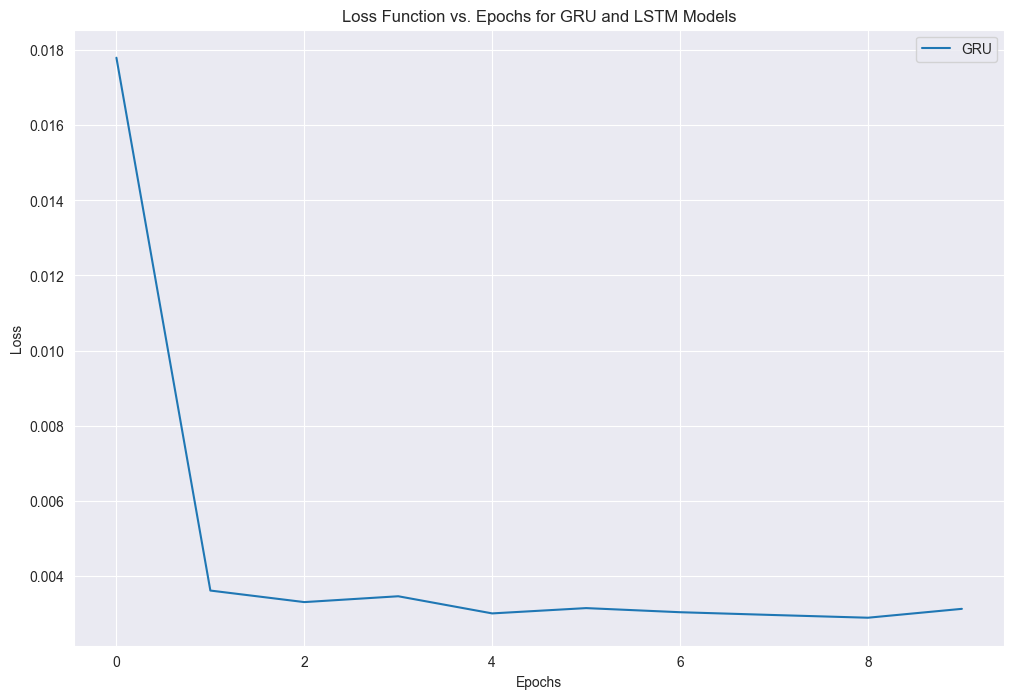

In [703]:
plt.figure(figsize=(12, 8))
for name, values in history.items():
    plt.plot(values['loss'], label=name)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs for GRU and LSTM Models')
plt.legend()
plt.show()

In [704]:
y_test_copy = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copy, (len(y_test), dataset.shape[1])))[:, 0]

In [705]:
results = {
    "MAE": [],
    "MSE": [],
    "EVS": []
}

for model in models:
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)

116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
GRU - MSE: 2.29
GRU - MAE: 1.03
GRU - EVS: 0.95
--------------------


In [706]:
prediction = models[0].predict(X_test)
prediction_copy_array = np.repeat(prediction, dataset.shape[1], axis=-1)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [707]:
pred = scaler.inverse_transform(np.reshape(prediction_copy_array, (len(prediction), dataset.shape[1])))[:, 0]

In [708]:
dates = df['date'].values
df_output = pd.DataFrame({"date": dates[-test_split + window_size:], 'Actual': y_test, 'Predicted': pred})
df_output.head(20)

,date,Actual,Predicted
0,2023-09-15 06:43:51+00:00,18.0,18.905436
1,2023-09-15 06:53:58+00:00,19.0,18.988592
2,2023-09-15 06:56:30+00:00,18.0,19.763948
3,2023-09-15 07:04:07+00:00,20.0,19.017193
4,2023-09-15 07:08:45+00:00,21.0,20.451801
5,2023-09-15 07:14:16+00:00,21.0,21.181210
6,2023-09-15 07:17:40+00:00,20.0,21.247448
7,2023-09-15 07:24:21+00:00,20.0,20.656620
8,2023-09-15 07:34:27+00:00,20.0,20.602377
9,2023-09-15 07:37:53+00:00,18.0,20.600630


In [726]:
def plot_results(df):
    plt.figure(figsize=(12, 8))
    plt.plot(df['date'], df['Actual'], label="Actual")
    plt.plot(df['date'], df['Predicted'], label="Predicted")
    plt.xlabel('Date')
    plt.ylabel('Available Bike Stands')
    plt.title('Actual vs. Predicted Available Bike Stands')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


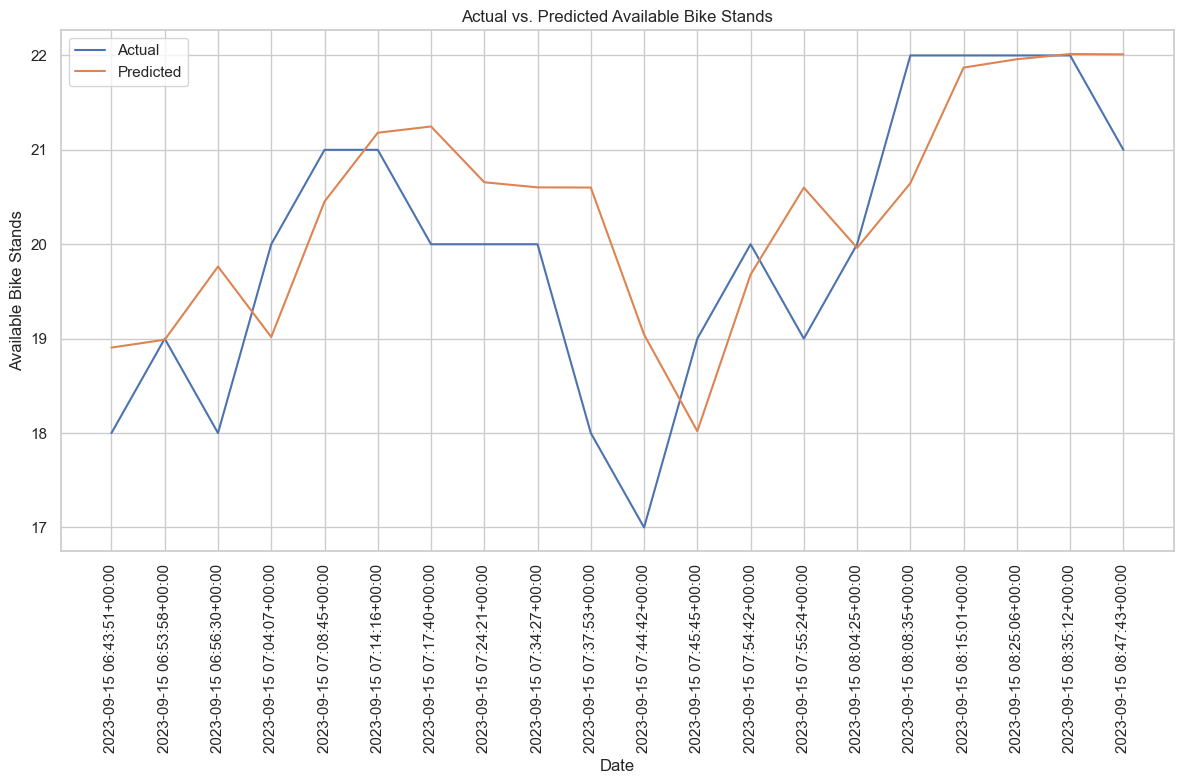

In [727]:
plot_results(df_output.head(20))

In [731]:
best_model = None
min_mse = float('inf')
for m in models:
    mse = results['MSE'][0][1]
    if mse < min_mse:
        min_mse = mse
        best_model = m

In [732]:
print("Best model:", best_model.name)
print("MSE:", min_mse)

Best model: GRU
MSE: 2.2873056487314827


In [733]:
joblib.dump(scaler, "../models/minmax_scaler.gz")
best_model.save(f"../models/mbajk_{best_model.name}_mse_{format(min_mse, ".2f")}.keras")